In [1]:
from lifelines import CoxPHFitter

In [2]:
from utils.config import load_datasets, get_train_dataset_indexes, get_generated_vae_dataset_indexes, get_generated_gan_dataset_indexes
                
dataset_indexes = get_generated_gan_dataset_indexes("../outputs/generated_datasets")
datasets = load_datasets(folder="../outputs/generated_datasets", names=dataset_indexes)

C:\Users\johan\anaconda3\envs\reseach_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [3]:
datasets['acath_train_gan'].dataframe()

,pid,event,time,num_age,num_choleste,fac_sex
0,1002.316196,0,45,63.761213,211.680029,M
1,3001.621263,1,19,54.338999,248.791982,F
2,2400.618062,1,14,55.567634,230.105610,M
3,1287.464060,1,12,53.989110,230.978517,M
4,2824.617229,0,15,57.017324,191.646418,M
...,...,...,...,...,...,...
4995,3087.847830,1,71,62.520260,228.791722,M
4996,1628.817666,0,246,69.311281,176.960831,M
4997,414.609397,0,38,56.321372,191.620442,F
4998,926.209715,1,14,41.042663,213.514314,M


In [4]:
from utils.preprocess import get_column_transformer

data_pre = datasets['acath_train_gan'].dataframe().drop(columns=['pid'], errors='ignore')
data = get_column_transformer(data_pre)


data

,ohe__fac_sex_M,remainder__event,remainder__time,remainder__num_age,remainder__num_choleste
0,1.0,0.0,45.0,63.761213,211.680029
1,0.0,1.0,19.0,54.338999,248.791982
2,1.0,1.0,14.0,55.567634,230.105610
3,1.0,1.0,12.0,53.989110,230.978517
4,1.0,0.0,15.0,57.017324,191.646418
...,...,...,...,...,...
4995,1.0,1.0,71.0,62.520260,228.791722
4996,1.0,0.0,246.0,69.311281,176.960831
4997,0.0,0.0,38.0,56.321372,191.620442
4998,1.0,1.0,14.0,41.042663,213.514314


In [5]:
from utils.preprocess import impute_missing_values

data_clean = impute_missing_values(data)


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
# Drop the columns related to duration and event as they should not be included in VIF calculation
X = data_clean.drop(columns=['remainder__time', 'remainder__event'])

# Add a constant term for the intercept
X = add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["Variable Inflation Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                  Variable  Variable Inflation Factor
0                    const                  77.817876
1           ohe__fac_sex_M                   1.002463
2       remainder__num_age                   1.002153
3  remainder__num_choleste                   1.002557


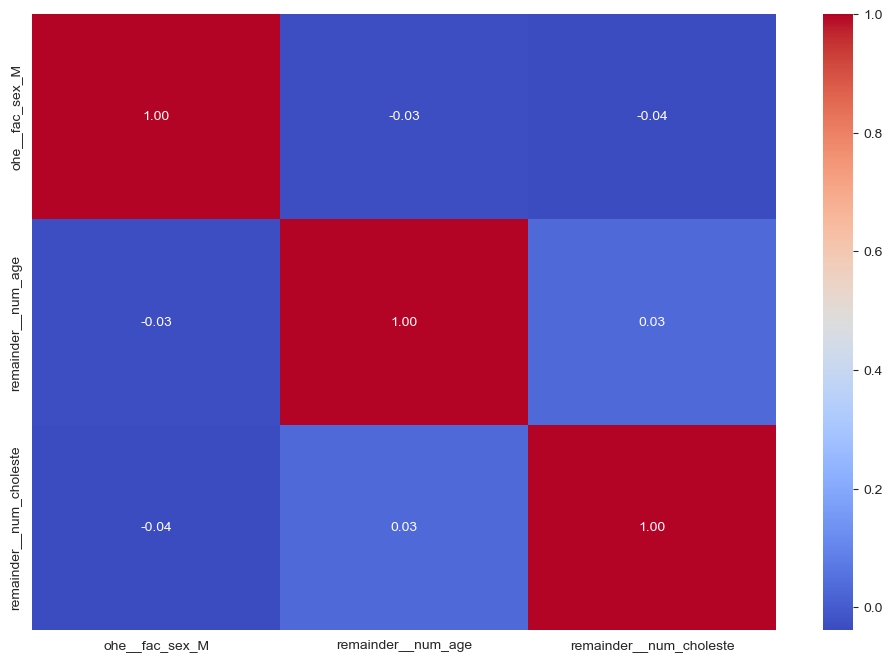

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the columns related to duration and event
corr_matrix = data_clean.drop(columns=['remainder__time', 'remainder__event']).corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


In [8]:
model = CoxPHFitter()
model.fit(data_clean, duration_col='remainder__time', event_col='remainder__event')
model.print_summary()

<lifelines.CoxPHFitter: fitted with 5000 total observations, 1670 right-censored observations>
             duration col = 'remainder__time'
                event col = 'remainder__event'
      baseline estimation = breslow
   number of observations = 5000
number of events observed = 3330
   partial log-likelihood = -24473.75
         time fit was run = 2024-08-09 08:35:34 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                
ohe__fac_sex_M           0.68      1.98      0.04            0.60            0.77                1.82                2.16
remainder__num_age      -0.04      0.96      0.00           -0.05           -0.04                0.95                0.96
remainder__num_choleste  0.00      1.00      0.00            0.00            0.00                1.00                1.00

                         cmp to      z      p  -log2(p)
covariate                                              
ohe__fac_sex_M             0.00  15.59 <0.005    179.69
remainder__num_age         0.00 -19.49 <0.005    278.51
remainder__num_choleste    0.00   5.17 <0.005     22.04
---
Concordance = 0.64
Partial AIC = 48953.51
log-likelihood ratio test = 613.51 on 3 df
-log2(p) of ll-ratio test = 438.25

In [15]:
model.predict_survival_function(data_clean)


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1.0,0.998393,0.998683,0.997623,0.997451,0.997940,0.998708,0.998926,0.998240,9.969014e-01,0.997609,...,0.998667,0.998445,0.998981,9.963459e-01,9.950079e-01,0.998243,0.998824,0.998928,9.957103e-01,0.998696
2.0,0.992528,0.993874,0.988963,0.988168,0.990427,0.993987,0.995002,0.991815,9.856299e-01,0.988897,...,0.993798,0.992766,0.995256,9.830708e-01,9.769284e-01,0.991832,0.994525,0.995008,9.801492e-01,0.993934
3.0,0.982707,0.985810,0.974517,0.972698,0.977877,0.986072,0.988415,0.981068,9.668963e-01,0.974368,...,0.985634,0.983257,0.989001,9.610675e-01,9.471592e-01,0.981106,0.987313,0.988428,9.544377e-01,0.985947
4.0,0.970350,0.975642,0.956440,0.953361,0.962137,0.976090,0.980095,0.967560,9.435713e-01,0.956187,...,0.975343,0.971287,0.981098,9.337786e-01,9.105854e-01,0.967624,0.978211,0.980118,9.226922e-01,0.975878
5.0,0.956588,0.964291,0.936436,0.931995,0.944672,0.964944,0.970788,0.952534,9.179165e-01,0.936070,...,0.963855,0.957950,0.972253,9.039035e-01,8.709934e-01,0.952627,0.968036,0.970821,8.881235e-01,0.964634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261.0,0.003650,0.010064,0.000247,0.000135,0.000748,0.010964,0.023529,0.002133,1.975462e-05,0.000235,...,0.009505,0.004369,0.028473,2.822916e-06,2.591797e-08,0.002160,0.016433,0.023630,3.043363e-07,0.010527
285.0,0.002643,0.007725,0.000153,0.000081,0.000494,0.008457,0.018964,0.001497,1.059439e-05,0.000145,...,0.007272,0.003197,0.023202,1.353639e-06,9.489256e-09,0.001517,0.012974,0.019051,1.283858e-07,0.008101
304.0,0.001721,0.005437,0.000081,0.000041,0.000285,0.005992,0.014242,0.000936,4.632588e-06,0.000077,...,0.005096,0.002111,0.017681,5.101797e-07,2.499695e-09,0.000949,0.009480,0.014312,4.081923e-08,0.005722
309.0,0.000920,0.003254,0.000032,0.000015,0.000128,0.003620,0.009370,0.000471,1.381865e-06,0.000030,...,0.003030,0.001151,0.011882,1.224624e-07,3.553638e-10,0.000478,0.005992,0.009420,7.640399e-09,0.003441


In [10]:
model.predict_median(data_clean)


0       30.0
1       36.0
2       22.0
3       21.0
4       25.0
        ... 
4995    28.0
4996    40.0
4997    43.0
4998    15.0
4999    36.0
Name: 0.5, Length: 5000, dtype: float64

In [12]:
model.predict_partial_hazard(data_clean)

0       0.828008
1       0.678376
2       1.225233
3       1.313919
4       1.061857
          ...   
4995    0.905412
4996    0.606057
4997    0.552472
4998    2.213459
4999    0.671743
Length: 5000, dtype: float64

<Axes: >

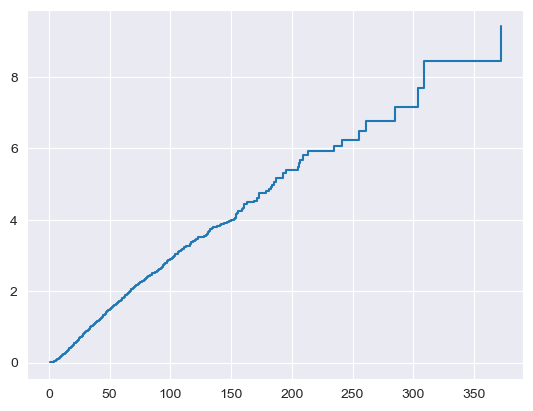

In [16]:
model.baseline_cumulative_hazard_["baseline cumulative hazard"].plot(drawstyle="steps-post", label="semi")

In [ ]:
model.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

In [18]:
model.check_assumptions(data_clean)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 5000 total observations, 1670 right-censored observations>
         test_name = proportional_hazard_test

---
                              test_statistic      p  -log2(p)
ohe__fac_sex_M          km             23.22 <0.005     19.40
                        rank           23.28 <0.005     19.45
remainder__num_age      km              0.13   0.72      0.48
                        rank            0.12   0.73      0.45
remainder__num_choleste km              6.69   0.01      6.69
                        rank            6.32   0.01      6.38



1. Variable 'ohe__fac_sex_M' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['ohe__fac_sex_M', ...]` in
the call in `.fit`. See documentation in link [E] below.

2. Variable 'remainder__num_choleste' failed the non-proportional test: p-value is 0.0097.

   Advice 1: the functional form of the variable 'remainder__num_choleste' might be incorrect. That
is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'remainder__num_choleste' using pd.cut, and then specify it in
`strata=['remainder__num_choleste', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/ju

[]